# Bayesian optimization

## Introduction 

Many optimization problems in machine learning are black box optimization problems where the objective function $f(\mathbf{x})$ is a black box function<sup>[1][2]</sup>. We do not have an analytical expression for $f$ nor do we know its derivatives. Evaluation of the function is restricted to sampling at a point $\mathbf{x}$ and getting a possibly noisy response. 

If $f$ is cheap to evaluate we could sample at many points e.g. via grid search, random search or numeric gradient estimation. However, if function evaluation is expensive e.g. tuning hyperparameters of  a deep neural network, probe drilling for oil at given geographic coordinates or evaluating the effectiveness of a drug candidate taken from a chemical search space then it is important to minimize the number of samples drawn from the black box function $f$.

This is the domain where Bayesian optimization techniques are most useful. They attempt to find the global optimimum in a minimum number of steps. Bayesian optimization incorporates prior belief about $f$ and updates the prior with samples drawn from $f$ to get a posterior that better approximates $f$. The model used for approximating the objective function is called *surrogate model*. Bayesian optimization also uses an *acquisition function* that directs sampling to areas where an improvement over the current best observation is likely.

### Surrogate model

A popular surrogate model for Bayesian optimization are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). I wrote about Gaussian processes in a [previous post](https://krasserm.github.io/2018/03/19/gaussian-processes/). If you are not familiar with GPs I recommend reading it first. GPs define a prior over functions and we can use them to incorporate prior beliefs about the objective function (smoothness, ...). The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement. 

### Acquisition functions

Proposing sampling points in the search space is done by acquisition functions. They trade off exploitation and exploration. Exploitation means sampling where the surrogate model predicts a high objective and exploration means sampling at locations where the prediction uncertainty is high. Both correspond to high acquisition function values and the goal is to maximize the acquisition function to determine the next sampling point. 



More formally, the objective function $f$ will be sampled at $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$ where $u$ is the acquisition function and $\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1),...,(\mathbf{x}_{t-1}, y_{t-1})\}$ are the $t-1$ samples drawn from $f$ so far. Popular acquisition functions are *maximum probability of improvement* (MPI), *expected improvement* (EI) and *upper confidence bound* (UCB)<sup>[1]</sup>. In the following, we will use the expected improvement (EI) which is most widely used and described further below. 

### Optimization algorithm

The Bayesian optimization procedure is as follows. For $t = 1,2,...$ repeat:

- Find the next sampling point $\mathbf{x}_{t}$ by optimizing the acquisition function over the GP: $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$
- Obtain a possibly noisy sample $y_t = f(\mathbf{x}_t) + \epsilon_t$ from the objective function $f$.
- Add the sample to previous samples $\mathcal{D}_{1:t} = \{\mathcal{D}_{1:t-1}, (\mathbf{x}_t,y_t)\}$ and update the GP.

### Expected improvement

Expected improvement is defined as

$$\mathrm{EI}(\mathbf{x}) = \mathbb{E}\max(f(\mathbf{x}) - f(\mathbf{x}^+), 0)\tag{1}$$

where $f(\mathbf{x}^+)$ is the value of the best sample so far and $\mathbf{x}^+$ is the location of that sample i.e. $\mathbf{x}^+ = \mathrm{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i)$. The expected improvement can be evaluated analytically under the GP model<sup>[3]</sup>:

$$
\mathrm{EI}(\mathbf{x}) =
\begin{cases}
(\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x})\phi(Z)  &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}\tag{2}
$$

where

$$
Z =
\begin{cases}
\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})} &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}
$$

where $\mu(\mathbf{x})$ and $\sigma(\mathbf{x})$ are the mean and the standard deviation of the GP pesterior predictive at $\mathbf{x}$, respectively. $\Phi$ and $\phi$ are the CDF and PDF of the standard normal distribution, respectively. The first summation term in Equation (2) is the exploitation term and second summation term is the exploration term.

Parameter $\xi$ in Equation (2) determines the amount of exploration during optimization and higher $\xi$ values lead to more exploration. In other words, with increasing $\xi$ values, the importance of improvements predicted by the GP posterior mean $\mu(\mathbf{x})$ decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large $\sigma(\mathbf{x})$ values. A recommended default value for $\xi$ is $0.01$.

With this minimum of theory we can start implementing Bayesian optimization. The next section shows a basic implementation with plain NumPy and SciPy, later sections demonstrate how to use existing libraries. Finally, Bayesian optimization is used to tune the hyperparameters of a tree-based regression model.

## Implementation with NumPy and gpReg action

In this section, we will implement the acquisition function and its optimization in plain NumPy and SciPy and use scikit-learn for the Gaussian process implementation. Although we have an analytical expression of the optimization objective `f` in the following example, we treat is as black box and iteratively approximate it with a Gaussian process during Bayesian optimization. Furthermore, samples drawn from the objective function are noisy and the noise level is given by the `noise` variable. Optimization is done within given `bounds`. We also assume that there exist 50 initial samples in `X_init` and `Y_init`.

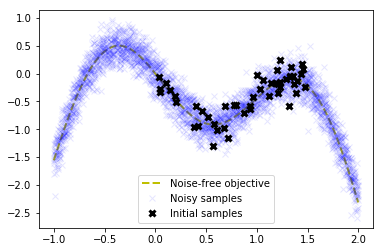

In [9]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    #return -np.sin(6*X) + noise * np.random.randn(*X.shape)
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.random.uniform(bounds[:, 0]+1, bounds[:, 1]-0.5, size=(50,1))
#X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)


import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.001).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

Goal is to find the global optimum on the left in a small number of steps. The next step is to implement the acquisition function defined in Equation (2) as `expected_improvement` function. 

In [10]:
from scipy.stats import norm
import pandas as pd
def expected_improvement(X, X_sample, Y_sample, s, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gprpredict(X, s, return_std=True)
    mu_sample = gprpredict(X_sample, s)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

We also need a function that proposes the next sampling point by computing the location of the acquisition function maximum. 

In [11]:
#from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, s, bounds,n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X: mesh grid
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    acq = acquisition(X, X_sample, Y_sample, s)
    idx = np.argmax(acq)
    #print(X[idx].reshape(-1, 1))
    return X[idx].reshape(-1, 1)
    


def propose_location2(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
    print(min_x)        
    return min_x.reshape(-1, 1)

In [12]:
def gprfit( X_sample, Y_sample, s, nIP):
    samplex = pd.DataFrame(X_sample,  columns=['x'])
    sampley = pd.DataFrame(Y_sample,  columns=['y'])
    sample  =pd.concat([samplex, sampley], axis=1)
    
    if s.tableexists('sample').exists:
        s.CASTable('sample').droptable()

    dataset = s.upload_frame(sample, 
                         importoptions=dict(vars=[dict(type='double'),
                                                  dict(type='double')
                                                  ]),
                          casout=dict(name='sample', promote=True))
    
    s.loadactionset(actionset="nonParametricBayes")
    s.gpreg(
      table={"name":"sample"},
      inputs={"x"},
      target="y", 
      seed=1234, 
      nInducingPoints=nIP,
      fixInducingPoints=False,
      kernel="Matern52",
      partbyfrac={"valid":0, "test":0, "seed":1235},
      nloOpts={"algorithm":"ADAM",
            "optmlOpt":{"maxIters":1000},
            "sgdOpt":{"learningRate":0.01,
                      "momentum":0.8,
                      "adaptiveRate":True,
                      "adaptiveDecay":0.9,
                      "miniBatchSize":100
                   },
               "validate":{"stagnation":5},
               "printOpt":{
                "printFreq":1000,
                "logLevel":1
            }
           },   
     # output={"casout":{"name":"GpReg_Pred", "replace":True}, "copyvars":"ALL"},
      outInducingPoints={"name":"GpReg_inducing", "replace":True},
      outVariationalCov={"name":"GpReg_S", "replace":True},
      saveState={"name":"gpregStore", "replace":True}
     )
    
    #S = s.CASTable("GpReg_S").to_frame() 
    #print(S.values)
   


In [13]:
def gprpredict(X1, s, return_std=True):
    test_data = pd.DataFrame(X1,  columns=['x'])
    #print(test_data)
    if s.tableexists('test_data').exists:
        s.CASTable('test_data').droptable()

    dataset = s.upload_frame(test_data, 
                        importoptions=dict(vars=[dict(type='double')]),
                          casout=dict(name='test_data', promote=True))

    s.score(
        table='test_data',
        out={"name":"test_pred", "replace":True},
        rstore='gpregStore',
    )
    test_pred = s.CASTable("test_pred").to_frame() 
    mu = test_pred['P_yMEAN'].values
    std = test_pred['P_ySTD'].values
    if return_std:
        return mu, std
    else:
        return mu

In [14]:
import sys
sys.path.insert(0, '\\\\newwinsrc\\sasgen\\dev\\mva-vb023\\GTKWX6ND\\misc\\python') # location of src  
import swat as sw
s = sw.CAS('rdcgrd327.unx.sas.com', 29640, nworkers=3)
s.sessionprop.setsessopt(caslib='CASUSER',timeout=31535000)

NOTE: 'CASUSER(yeliu1)' is now the active caslib.


+ Elapsed: 0.00999s, user: 0.0146s, sys: 0.0135s, mem: 1.41mb

In [15]:
def plot_approximation2(s, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gprpredict(X, s, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

Now we have all components needed to run Bayesian optimization with the [algorithm](#Optimization-algorithm) outlined above. The Gaussian process in the following example is configured with a [Matérn kernel](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) which is a generalization of the squared exponential kernel or RBF kernel. 

Bayesian optimization runs for 10 iterations. In each iteration, a row with two plots is produced. The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. The right plot shows the acquisition function. The vertical dashed line in both plots shows the proposed sampling point for the next iteration which corresponds to the maximum of the acquisition function.

NOTE: Added action set 'aStore'.
NOTE: Cloud Analytic Services dropped table sample from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file available as table SAMPLE in caslib CASUSER(yeliu1).
NOTE: The table SAMPLE has been created in caslib CASUSER(yeliu1) from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'nonParametricBayes'.
NOTE: Action reset useLocking to TRUE.
NOTE: Beginning optimization of Gaussian Process Regression model...
NOTE: The OPTML solver is called.
NOTE: The SGD algorithm is used.
             Progress    Objective           Loss
                    1 7004627.99519 7004627.99519
                 1000      54.06922      54.06922
NOTE: The optimization has performed the desired number of epochs.
NOTE: Optimization complete.
NOTE: Cloud Analytic Services dropped table test_data from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file available as table TEST_DATA in caslib CASUSER(yeliu1).
NOT

NOTE: Cloud Analytic Services made the uploaded file available as table TEST_DATA in caslib CASUSER(yeliu1).
NOTE: The table TEST_DATA has been created in caslib CASUSER(yeliu1) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services dropped table test_data from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file available as table TEST_DATA in caslib CASUSER(yeliu1).
NOTE: The table TEST_DATA has been created in caslib CASUSER(yeliu1) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services dropped table test_data from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file available as table TEST_DATA in caslib CASUSER(yeliu1).
NOTE: The table TEST_DATA has been created in caslib CASUSER(yeliu1) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services dropped table test_data from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file av

NOTE: Cloud Analytic Services dropped table sample from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file available as table SAMPLE in caslib CASUSER(yeliu1).
NOTE: The table SAMPLE has been created in caslib CASUSER(yeliu1) from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'nonParametricBayes'.
NOTE: Action reset useLocking to TRUE.
NOTE: Beginning optimization of Gaussian Process Regression model...
NOTE: The OPTML solver is called.
NOTE: The SGD algorithm is used.
             Progress    Objective           Loss
                    1 9631385.22499 9631385.22499
                 1000      54.19174      54.19174
NOTE: The optimization has performed the desired number of epochs.
NOTE: Optimization complete.
NOTE: Cloud Analytic Services dropped table test_data from caslib CASUSER(yeliu1).
NOTE: Cloud Analytic Services made the uploaded file available as table TEST_DATA in caslib CASUSER(yeliu1).
NOTE: The table TEST_DATA has been c

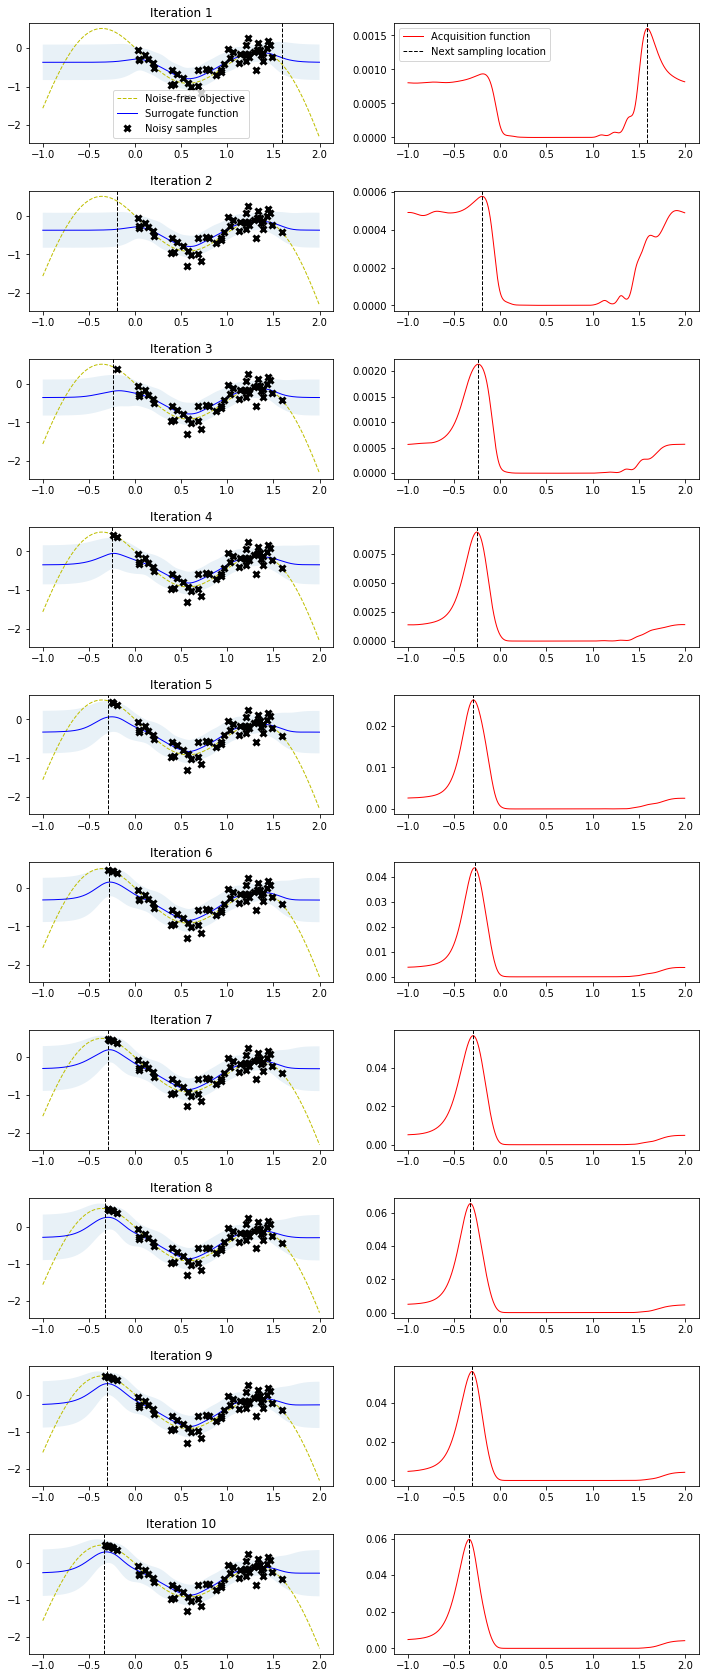

In [16]:
from bayesian_optimization_util import plot_acquisition
# Initialize samples
X_sample = X_init
Y_sample = Y_init


# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)
    
s.loadactionset('aStore')

for i in range(n_iter):
    # Update Gaussian process with existing samples
    nIP = X_sample.shape[0]
    gprfit(X_sample, Y_sample, s, nIP )
    
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, s, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise=0)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation2(s, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    ei = expected_improvement(X, X_sample, Y_sample, s)
    plot_acquisition(X, ei, X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))